##### Author : 김재현
##### Created : 2021-06-23
##### Description : 기능에 따라 해당 코드의 관련 정보를 확인 및 시각화. MACD, OSC 값을 기준으로 판단한다.
##### 
##### 1. 기능
##### - seeAll = 4개월간 이동평균선이 상승국면에 있으나 1달간 단기 하락중인 종목 코드 리스트업
##### - search = 배당을 비롯한 세부정보 및 차트 제공 
##### 
##### 2. 제한사항
##### - 미국 주식의 경우에만 select 이용 가능
##### - 반복되는 코드, 잦은 전역변수 호출
##### - 코드 종료 시 검색한 차트 일괄 출현
##### 
##### 3. 참고링크
##### - https://md2biz.tistory.com/397 각종 지표별 의미
##### - https://nakyup.tistory.com/5 각종 지표 가공
##### - https://m.blog.naver.com/silvury/221312883764 배당정보 크로울링

In [5]:
# 필요한 라이브러리

import FinanceDataReader as web
import pandas_datareader.data as pdweb
from datetime import date, timedelta
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import time

import csv
import urllib
from bs4 import BeautifulSoup as bs

from PIL import Image as pl

want to decide your settings? if not, default values will be init.(y/n)


 n




[MOD_SELECT]
seeAll = show all stock datas of market which u selected.
search = search some stocks which you want, it will show charts and recent dividend infos.
exit = exit codes


 search



[input ur target stock code.]


 TSLA



you just searched  TSLA ,
drawing complete. chart will be pop-up soon.

[SEARCHED_RESULT
['selected stock code : ', 'TSLA', 'long-term in stock prices : decline', 'short-term in stock prices : rise', 'ticker : TSLA, Annual Dividends : no data exists, Market odds : no data exists, Recent Close : 656.02']

[MOD_SELECT]
seeAll = show all stock datas of market which u selected.
search = search some stocks which you want, it will show charts and recent dividend infos.
exit = exit codes


 exit


exit codes.


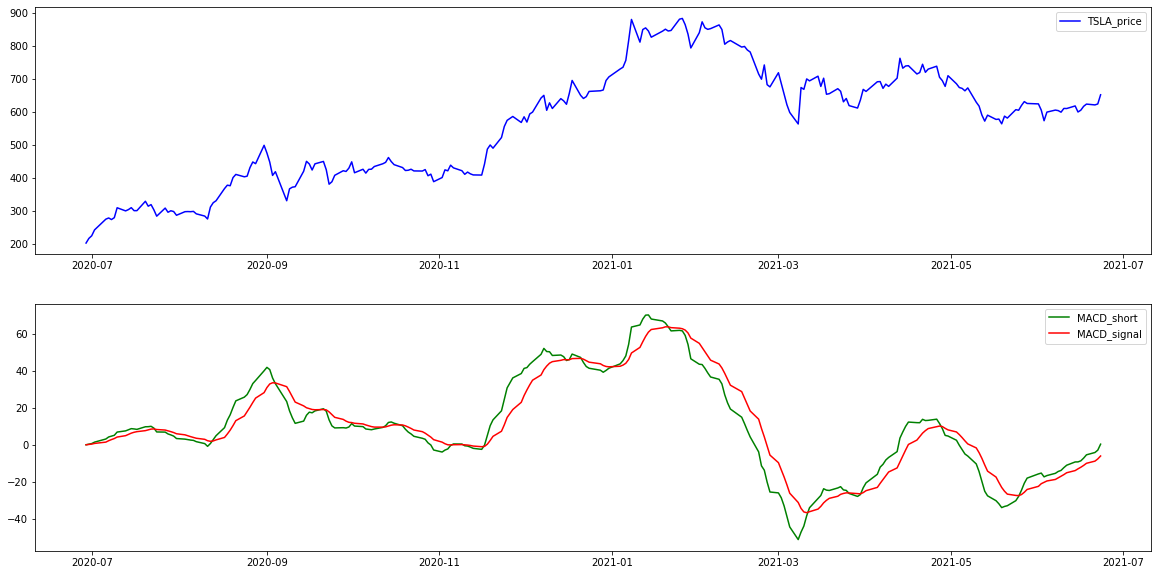

In [29]:
#### 필요값 (전역변수) 및 실행

market = ""
today = date.today()
startday = date.today() - timedelta(360)
yesterday = date.today() - timedelta(1)
trigger = 0
allResStr = ["recommanded stocks : "]
schResStr = ["selected stock code : "]
resChart = plt
SEC = web
stockCode = ""
rows = []

main()

In [30]:
# 전체 가동 코드

def main():
    global startday
    global market
    global trigger
    global allResStr
    global schResStr
    global resChart

    while(True):
        print("want to decide your settings? if not, default values will be init.(y/n)")
        menubtn = input()
        print("")
        if menubtn == "y":
            settings()
            time.sleep(3)
            create_data(market)
            break
        elif menubtn == "n":
            startday = date.today() - timedelta(360)
            market = "NASDAQ"
            trigger = 10
            break
        else:
            print("selected wrong button, want to decide your settings?(y/n)")

    while(True):
        print("\n[MOD_SELECT]"
              , "seeAll = show all stock datas of market which u selected."
              , "search = search some stocks which you want, it will show charts and recent dividend infos."
              , "exit = exit codes", sep='\n')
        menubtn = input()
        if menubtn == "seeAll":
            allResStr = ["recommanded stocks : "]
            get_recommanded(trigger)
            print(allResStr)
        elif menubtn == "search":
            schResStr = ["selected stock code : "]
            resChart = plt
            get_searched()
            img = pl.open('./chartSet/searchedChart_' + str(stockCode) + '.png')
            img.show()
            print("", "[SEARCHED_RESULT", schResStr, sep='\n')
        elif menubtn == "exit":
            print("exit codes.")
            break
        else:
            print("you just selected wrong menu.")
            print("")

            
            
# seeAll - 기본 클래스
# trigger에 설정된 수만큼 조건에 맞는 회사의 코드를 리턴한다.

def get_recommanded(trigger):
    
    codefilename = './stockDataSet/marketList_' + str(market) + '.csv'
    count = 0
    global allResStr

    try:
        with open(codefilename, 'r', newline='') as file:
            print("\nloading entire data complete.")

            codefilename = pd.read_csv("./stockDataSet/marketList_NASDAQ.csv")
            symbolList = codefilename.loc[:, "Symbol"]
        
        for i in range (0, len(symbolList)):

            SEC = web.DataReader(symbolList[i], startday, yesterday).reset_index()
            SEC["MA_12"]=SEC["Close"].ewm(span=12).mean()
            SEC["MA_26"]=SEC["Close"].ewm(span=26).mean()
            SEC["MA_50"]=SEC["Close"].ewm(span=50).mean()
            SEC["MA_120"]=SEC["Close"].ewm(span=120).mean()
            SEC["MACD_long"] = SEC.apply(lambda x: (x["MA_50"]-x["MA_120"]), axis=1)
            SEC["MACD_short"] = SEC.apply(lambda x: (x["MA_12"]-x["MA_26"]), axis=1)
            SEC["MACD_signal"] = SEC["MACD_short"].ewm(span=9).mean()
            SEC["MACD_oscillator"] = SEC.apply(lambda x:(x["MACD_short"]-x["MACD_signal"]), axis=1)

            # 비교대상 값 불러옴 - MACD, 오늘 기준 OSC, 3일 전 OSC
            resList = [float(SEC.loc[len(SEC)-1:len(SEC), "MACD_long"]), 
                       float(SEC.loc[len(SEC)-1:len(SEC), "MACD_oscillator"])]

            if (resList[0] > 0):
                
                if (resList[1] < 0):
                    allResStr.append(symbolList[i] + ", ")
                    count += 1
                    print(symbolList[i], "appended++")
                    
                    if (count == int(trigger)):
                        break

    except:
        print("loading error occured, restart session or reset your settings.")

        
        
# search - 검색 주식 정보 출력

def get_searched():
    
    global schResStr
    global startday
    global yesterday
    global SEC
    global stockCode

    print("\n[input ur target stock code.]")
    stockCode = input()

    print("\nyou just searched ", stockCode, ",")

    try:
        SEC = web.DataReader(stockCode, startday, yesterday)

    except:
        print("your stock code doesn't exist in List.")

    schResStr.append(stockCode)
    SEC["MA_12"]=SEC["Close"].ewm(span=12).mean()
    SEC["MA_26"]=SEC["Close"].ewm(span=26).mean()
    SEC["MA_50"]=SEC["Close"].ewm(span=50).mean()
    SEC["MA_120"]=SEC["Close"].ewm(span=120).mean()
    SEC["MACD_long"] = SEC.apply(lambda x: (x["MA_50"]-x["MA_120"]), axis=1)
    SEC["MACD_short"] = SEC.apply(lambda x: (x["MA_12"]-x["MA_26"]), axis=1)
    SEC["MACD_signal"] = SEC["MACD_short"].ewm(span=9).mean()
    SEC["MACD_oscillator"] = SEC.apply(lambda x:(x["MACD_short"]-x["MACD_signal"]), axis=1)

    # 차트 형성
    get_draw_selected(stockCode, SEC)

    # 마지막 행의 값을 추출하기 위해 인덱스 리셋
    SEC = SEC.reset_index()

    resList = [float(SEC.loc[len(SEC)-1:len(SEC), "MACD_long"]), 
                float(SEC.loc[len(SEC)-1:len(SEC), "MACD_oscillator"])]

    if (resList[0] < 0):
        schResStr.append("long-term in stock prices : decline")
    else:
        schResStr.append("long-term in stock prices : rise")

    if (resList[1] < 0):
        schResStr.append("short-term in stock prices : decline")
    else:
        schResStr.append("short-term in stock prices : rise")
        
    # 배당정보 형성
    get_dividend_data(stockCode)
    schResStr.append('ticker : ' + str(rows[0][0])
                     + ', Annual Dividends : ' + str(rows[0][1])
                     + ', Market odds : ' + str(rows[0][2])
                     + ', Recent Close : ' + str(rows[0][3]))

    
    
# search - 차트 도식 및 저장

def get_draw_selected(stockCode, SEC):
    
    try:
        fig = plt.figure(figsize = (20, 10))

        x = SEC.index
        y = SEC['Close']
        y2 = SEC['MACD_short']
        y3 = SEC['MACD_signal']

        ax1 = fig.add_subplot(2,1,1)
        ax2 = fig.add_subplot(2,1,2)

        ax1.plot(x, y, "b", label = stockCode + "_price")
        ax1.legend(loc = 1)
        ax2.plot(x, y2, "g", label = "MACD_short")
        ax2.plot(x, y3, "r", label = "MACD_signal")
        ax2.legend(loc = 1)

        plt.savefig('./chartSet/searchedChart_' + str(stockCode) + '.png')
        print("drawing complete. chart will be pop-up soon.")

    except:
        print("drawing error.")

        
        
# search - 배당정보 형성 클래스 생성

def set_dividend_data(stockCode):
    
    divdata = []
    url = "https://finance.yahoo.com/quote/" + stockCode + "?p=" + stockCode
    rows = bs(urllib.request.urlopen(url).read()).findAll('table')[1].tbody.findAll('tr')

    for i in rows:
        divs = i.findAll('td')
        if 'Forward Dividend' in str(divs[0]):
            div_and_yield = divs[1].text
            dividend, div_yield = div_and_yield.split(" ")
            a = div_yield.replace("(","")
            b = a.replace(")","")
            # 배당이력이 없을 시 예외처리
            try:
                divdata.append([float(dividend), str(b)])
            except:
                divdata.append(["no data exists", "no data exists"])
    return divdata



# search - 배당정보 appender

def get_dividend_data(stockCode):
    
    global rows
    rows = []
    
    df = pdweb.DataReader(stockCode, 'yahoo', startday, yesterday)
    dividend_data = set_dividend_data(stockCode)
    row = [stockCode, dividend_data[0][0], dividend_data[0][1], round(float(df.iloc[-1][0]),2)]
    rows.append(row)

    
    
# 가동일 기준 데이터를 로드, 스톡리스트를 생성해줄 클래스 생성

def create_data(market):
    
    codefilename = './stockDataSet/marketList_' + str(market) + '.csv'
    
    # 목표 시장 선택 및 데이터 로드
    print("loading entire stockcode data from market..")
    print("")
    try:
        # file 존재여부 확인
        with open(codefilename, 'r', newline='') as file:
            print("list already exists, proceed to next steps.")
    except:
        try:
            print("")
            print("list none-exists. load marketList which you requested.")
            targetMarket = web.StockListing(market)
            print("loading complete. making lists..")
            print("")

            targetMarket.to_csv('./stockDataSet/marketList_' + str(market) + '.csv')
            time.sleep(3)
            print("list created, initialize to next steps.")

        except:
            time.sleep(3)
            print("")
            print("loading error occured, please try again or check ur status.")

            
            
# 기본값 입력받을 클래스

def settings():
    
    print("[market list]"
          , "KRX(한국전체), KOSPI(코스피전체), KOSDAQ(코스닥전체), KONEX(코넥스전체) - 배당 구현중"
          , "NASDAQ(나스닥종목), NYSE(뉴욕증권거래소), AMEX(AMEX종목), SP500(S&P500 종목)"
          , ""
          , "'dayago' decieds your startday to crawl data. it needs to set 'dayago' at least 120. (1 year recommanded.)"
          , "", sep='\n')
    
    print("\n==SET your target market.")
    global market
    market = input()
    
    print("\n==SET your 'dayago'.")
    dayago = input()
    
    print("\n==SET your result length.")
    global trigger
    trigger = input()

    global startday
    startday = date.today() - timedelta(int(dayago))
        
    print(""
          , "**** Data has been set. make sure ur market. if it doesn't match with the list above, then it will occur some ERRORS. ****"
          , ""
          , "init datas : "
          , "",sep='\n')

    print("market : ", market)
    print("startday(dayago) : ", startday, "(", dayago, ")")
    print("result length : ", trigger)
    print("", sep='\n')